# Spacer on Jupyter

This is an interactive document. You can follow along on the cloud, change, play, go deeper into the code.

Slides accompanying this notebook are available [here](https://arieg.bitbucket.io/pdf/synasc2019.pdf).

To create your own copy:
 
 1. Go to https://notebooks.azure.com/arie-gurfinkel/projects/spacerexamples
 2. Create an Azure Notebooks account
 3. **Clone** `spacerexamples` project into your space
 4. Start `Dagstuhl2019.ipynb` notebook
 
If you get an error about `z3` package not being found, wait a little and try again. It takes some time for the underlying virtual machine to get provisioned with all the necessary pacakges.

In [1]:
import sys
!{sys.executable} -m pip install z3-solver

You should consider upgrading via the '/Users/arie/ag/git/spacer-on-jupyter/venv/bin/python -m pip install --upgrade pip' command.


In [26]:
import sys
import z3

class HtmlStr(object):
    def __init__(self, s):
        self._s = str(s)
        self._s = self._s.replace('\n', '<br/>')

    def _repr_html_(self):
        return self._s

    def __repr__(self):
        return repr(self._s)
    def __str__(self):
        return str(self._s)

def chc_to_str(chc):
    if z3.in_html_mode():
        return chc_to_html(chc)
    else:
        return chc_to_txt(chc)

def chc_to_html(chc):
    import io
    out = io.StringIO()

    for cls in chc:
        print(cls, '<br/>', file=out)

    return HtmlStr(out.getvalue())

def chc_to_txt(chc):
    import io
    out = io.StringIO()
    for cls in chc:
        print(cls, file=out)
    return out.getvalue()

class SpacerProof(object):
    def __init__(self, pf_ast):
        # strip off last mp to false
        self._ast = pf_ast.children()[0]

    def _get_fact(self, ast):
        return ast.children()[-1]

    def _to_dot_rec(self, ast, graph, visited):
        if ast.get_id() in visited:
            return

        visited.add(ast.get_id())

        dst = str(self._get_fact(ast).get_id())
        kids = ast.children()
        for k in kids[1:-1]:
            k_fact = self._get_fact(k)
            if k_fact.get_id() not in visited:
                graph.node(str(k_fact.get_id()), str(k_fact))
                visited.add(k_fact.get_id())
                self._to_dot_rec(k, graph, visited)
            graph.edge(str(k_fact.get_id()), dst)

    def to_dot(self):
        import graphviz
        g = graphviz.Digraph()

        visited = set()

        fact = self._get_fact(self._ast)
        id = fact.get_id()
        g.node(str(id), str(fact))
        visited.add(id)
        self._to_dot_rec(self._ast, g, visited)
        return g

    def _repr_mimebundle_(self, include, exclude, **kwargs):
        return self.to_dot()._repr_mimebundle_(include, exclude, **kwargs)

    def __str__(self):
        return str(self.to_dot())
    def raw(self):
        return self._ast


# proof mode must be enabled before any expressions are created
z3.set_param(proof=True)
z3.set_param(model=True)
# print expressions with HTML
z3.set_html_mode(True)

## Craig Interpolation

Let $A$ and $B$ be two formulas such that $A \wedge B$ is unsat. A __Craig Interpolant__ of $A$ and $B$ is a formula $Itp$ such that:

  1. $A \implies Itp$
  2. $Itp \wedge B \implies False$
  3. uninterpreted symbols of $Itp$ are those that are shared between $A$ and $B$
  
Craig Interpolation is at a core of many SMT- and SAT-based verification algorithms. 
Computing Craig Interpolants is one of the most requested (missing) features of Z3.
__But__, Craig Interpolation is reducible to CHC satisfiability!

$Itp$ is an interpolant of $A \wedge B$ if and only if, $Itp$ is a satisfying assignment to the following CHC:

  1. $\forall a, c \cdot A(a, c) \implies Itp(c)$
  2. $\forall b, c \cdot Itp(c) \wedge B(b, c) \implies False$
 
where uninterpreted constants $c$ are shared between $A$ and $B$, and uninterpreted constants $a$ and $b$ are  local to $A$ and $B$, respectively.

In [3]:
# compute uninterpreted constants in a formula
def free_arith_vars(fml):
    '''Returns the set of all integer uninterpreted constants in a formula'''
    seen = set([])
    vars = set([])

    int_sort = z3.IntSort()
    def fv(seen, vars, f):
        if f in seen:
            return
        seen |= { f }
        if f.sort().eq(int_sort) and f.decl().kind() == z3.Z3_OP_UNINTERPRETED:
            vars |= { f }
        for ch in f.children():
            fv(seen, vars, ch)
    fv(seen, vars, fml)
    return vars

In [4]:
# wrapper to solve CHC constraints and extract result
def solve_horn(chc, pp=False, q3=False, max_unfold=10, verbosity=0):
    z3.set_param(verbose=verbosity)

    s = z3.SolverFor('HORN')
    s.set('engine', 'spacer')
    s.set('spacer.order_children', 2)
    if not pp:
        s.set('xform.inline_eager', False)
        s.set('xform.inline_linear', False)
        s.set('xform.slice', False)

    if max_unfold > 0:
        s.set('spacer.max_level', max_unfold)

    if q3:
        # allow quantified variables in pobs
        s.set('spacer.ground_pobs', False)
        # enable quantified generalization
        s.set('spacer.q3.use_qgen', True)

    # add constraints to solver
    s.add(chc)
    if verbosity > 0:
        print(s.sexpr())
    # run solver
    res = s.check()
    # extract model or proof
    answer = None
    if res == z3.sat:
        answer = s.model()
    elif res == z3.unsat:
        answer = s.proof()
    return res, answer

In [5]:
# Binary Craig Interpolation by reduction to CHC
def interpolate(A, B, verbosity=0):
    '''Computes a Craig interpolant between A and B'''
    As = free_arith_vars(A)
    Bs = free_arith_vars(B)

    shared = [s for s in As & Bs ]

    Itp = z3.Function('Itp', [s.sort() for s in shared] + [z3.BoolSort()])
    left = z3.ForAll([a for a in As], z3.Implies(A, Itp(shared)))
    right = z3.ForAll([b for b in Bs], z3.Implies(Itp(shared), z3.Not(B)))

    res, answer = solve_horn([left, right])

    if res == z3.sat:
        return answer.eval(Itp(shared))
    return None

In [6]:
a, b, x, y = z3.Ints('a b x y')
itp = interpolate(z3.And(a < x, x < b), z3.And(b < a))

In [7]:
itp

&not;(b + -1&middot;a &le; 1)

## Principle of Induction

Symbolic reachability problem $P$ is a tuple $(v, Init, Tr, Bad)$, where 
   1. $V$ is a set of state variables
   2. $Init$ is a formula over $v$ describing the set of initial states
   3. $Tr$ is a formula $v$ and $v'$ describing the transition relation
   4. $Bad$ is a formula over $v$ describing the set of bad (or error) states
   
**Principle of Induction**: $P$ is **SAFE** if and only if there exists a formula $Inv(v)$ such that
   1. (Initiation) $Init \implies Inv$
   2. (Induction) $Inv \wedge Tr \implies Inv'$
   3. (Safety) $Inv \wedge Bad \implies False$
   
The formula $Inv$ is called an **inductive hypothesis**. Finding the right inductive hypothesis is reducible to deciding satifiability of the CHC that follow directly from the definition of principle of induction.

We begin by definition a class `Ts` to represent a transition system. It has three fields, `Init`, `Tr`, and `Bad` to represent the three corresponding components, and lots of additional code to manage state and input variables

In [8]:
class Ts(object):
    """A transition system

    Example usage
    >>> T = Ts('Ts0')
    >>> x, x_out = T.add_var(z3.IntSort(), name='x')
    >>> T.Init = x <= 0
    >>> T.Tr = z3.And(x < 5, x_out == x + 1)
    >>> T.Bad = x >= 10
    >>> T                                   #doctest: +NORMALIZE_WHITESPACE
    Transition System: Ts0
        Init: v_0 <= 0
        Bad: v_0 >= 10
        Tr: And(v_0 < 5, v_out_0 == v_0 + 1)
    """
    def __init__(self, name='Ts'):
        # string name
        self.name = name
        # state variables (pair of input and output)
        self._vars = []
        # inputs
        self._inputs = []
        # a map from optional names to state variables
        self._named_vars = dict()

        # maps state variable index to optional name
        self._var_names = list()

        # Transition relation
        self.Tr = z3.BoolVal(True)
        # Initial condition
        self.Init = z3.BoolVal(True)
        # Bad states
        self.Bad = z3.BoolVal(False)


    def add_var(self, sort, name=None):
        '''Add a state variable of a given sort. Returns a pair (pre, post)
           of a pre- and post- state versions of the variable
        '''
        pre, post = self._new_var_name(name=name)
        v_in = z3.Const(pre, sort)
        v_out = z3.Const(post, sort)
        self._vars.append((v_in, v_out))
        self._var_names.append(name)
        if name is not None:
            self._named_vars[name] = (v_in, v_out) 

        return (v_in, v_out)

    def get_var(self, idx):
        """Returns a pair of pre- and post-variables with a given index or name

        If idx is not an int it is interpreted as a name.
        Otherwise, it is interpreted as a variable index.

        >>> T = Ts('Ts0')
        >>> x, x_out = T.add_var(z3.IntSort(), name='x')
        >>> y, y_out = T.add_var(z3.IntSort(), name='y')
        >>> x
        v_0

        >>> T.get_var(1)
        (v_1, v_out_1)

        >>> T.get_var('x')
        (v_0, v_out_0)

        """
        if isinstance(idx, int):
            return self._vars[idx]
        elif idx in self._named_vars:
            return self._named_vars[idx]
        return None

    def get_var_name(self, idx):
        if idx < len(self._var_names):
            return self._var_names[idx]
        return None

    def get_pre_var(self, idx):
        """Returns a pre-state variable with a given name/index"""
        res = self.get_var(idx)
        if res is not None:
            return res[0]
        return None

    def get_pre_vars(self, vars):
        """Returns a tuple of pre-state variables with given names"""
        return (self.get_pre_var(v) for v in vars.split())

    def get_post_var(self, idx):
        """Returns a post-state variable with a given name"""
        res = self.get_var(idx)
        if res is not None:
            return res[1]
        return None

    def add_input(self, sort, name=None):
        '''Add an input of a given sort'''
        v = z3.Const(self._new_input_name(name=name), sort)
        self._inputs.append(v)
        return v

    def inputs(self):
        return self._inputs
    def pre_vars(self):
        return [u for (u, v) in self._vars]
    def post_vars(self):
        return [v for (u, v) in self._vars]
    def vars(self):
        return self.pre_vars() + self.post_vars()
    def pre_post_vars(self):
        return self._vars
    def all(self):
        return self.vars() + self.inputs()
    def sig(self):
        return [v.sort() for (u, v) in self._vars]
    def to_post(self, e):
        '''Rename expression over pre-state variables to post-state variables

        >>> T = Ts('Ts0')
        >>> x, x_out = T.add_var(z3.IntSort(), 'x')
        >>> y, y_out = T.add_var(z3.IntSort(), 'y')
        >>> e = x > y
        >>> T.to_post(x > y)
        v_out_0 > v_out_1
        '''
        return z3.substitute(e, *self._vars)

    def _new_input_name(self, name=None):
        if name is not None:
            return str(name)
        else:
            return self._mk_input_name(len(self._inputs))

    def _mk_input_name(self, idx):
        return 'i_' + str(idx)

    def _new_var_name(self, name=None):
        if name is not None:
            assert name not in self._named_vars
            assert str(name) not in self._named_vars
            return str(name), str(name) + "'" 
        else:
            idx = len(self._vars)
            return self._mk_var_name(idx), self._mk_post_var_name(idx)

    def _mk_var_name(self, idx):
        return 'v_' + str(idx)
    def _mk_post_var_name(self, idx):
        return 'v_out_' + str(idx)

    def __repr__(self):
        return 'Transition System: ' + self.name + '\n' + \
            '\tInit: ' + str(self.Init) + '\n' + \
            '\tBad: ' + str(self.Bad) + '\n' + \
            '\tTr: ' + str(self.Tr)

    def __str__(self):
        return repr(self)

We now define a transition system that counts. The definition is wrapped in a method since we will use it multiple times. We create two versions, one safe and one unsafe:

In [9]:
def mk_ts0(safe=True):
    T = Ts('Ts0')
    x, x_out = T.add_var(z3.IntSort(), name='x')
    T.Init = x <= 0
    T.Tr = z3.And(x < 5, x_out == x + 1)
    if safe:
        T.Bad = x >= 10
    else:
        T.Bad = x >= 4
    return T

In [10]:
ts0 = mk_ts0(safe=True)
HtmlStr(ts0)

"Transition System: Ts0<br/>\tInit: x &le; 0<br/>\tBad: x &ge; 10<br/>\tTr: x &lt; 5 &and; x' = x + 1"

We define a function `vc_gen` that generates **verification conditions** using the principle of induction:

In [11]:
def vc_gen(T):
    '''Verification Condition (VC) for an Inductive Invariant'''
    Inv = z3.Function('Inv', *(T.sig() + [z3.BoolSort()]))

    InvPre = Inv(*T.pre_vars())
    InvPost = Inv(*T.post_vars())

    all_vars = T.all()
    vc_init = z3.ForAll(all_vars, z3.Implies(T.Init, InvPre))
    vc_ind = z3.ForAll(all_vars, z3.Implies(z3.And(InvPre, T.Tr), InvPost))
    vc_bad = z3.ForAll(all_vars, z3.Implies(z3.And(InvPre, T.Bad), z3.BoolVal(False)))
    return [vc_init, vc_ind, vc_bad], InvPre

In [12]:
vc, inv = vc_gen(ts0)

In [13]:
chc_to_str(vc)

"&forall;x, x' : x &le; 0 &rArr; Inv(x) <br/><br/>&forall;x, x' : Inv(x) &and; x &lt; 5 &and; x' = x + 1 &rArr; Inv(x') <br/><br/>&forall;x, x' : Inv(x) &and; x &ge; 10 &rArr; False <br/><br/>"

In [14]:
HtmlStr(inv)

'Inv(x)'

In [15]:
res, answer = solve_horn(vc)

In [16]:
res

<b>sat</b>

In [17]:
answer

[Inv = [else &rarr; &not;(&#957;<sub>0</sub> &ge; 6)]]

In [18]:
answer.eval(inv)

&not;(x &ge; 6)

In [19]:
ts0 = mk_ts0(safe=False)
HtmlStr(ts0)

"Transition System: Ts0<br/>\tInit: x &le; 0<br/>\tBad: x &ge; 4<br/>\tTr: x &lt; 5 &and; x' = x + 1"

In [20]:
vc, inv = vc_gen(ts0)
res, answer = solve_horn(vc)
HtmlStr(res)

'<b>unsat</b>'

In [21]:
answer

mp(hyper-res(asserted(&forall;A : Inv(A) &and; A &ge; 4 &rArr; query!19(A)),
             hyper-res(asserted(&forall;A, B :
                                 Inv(A) &and;
                                 &not;(5 &le; A) &and;
                                 B = 1 + A &rArr;
                                 Inv(B)),
                       hyper-res(asserted(&forall;A, B :
                                        Inv(A) &and;
                                        &not;(5 &le; A) &and;
                                        B = 1 + A &rArr;
                                        Inv(B)),
                                 hyper-res(asserted(&forall;A, B :
                                        Inv(A) &and;
                                        &not;(5 &le; A) &and;
                                        B = 1 + A &rArr;
                                        Inv(B)),
                                        hyper-res(asserted(&forall;A,
                                        B :
                                        Inv(A) &and;
                                        &not;(5 &le; A) &and;
                                        B = 1 + A &rArr;
                                        Inv(B)),
                                        hyper-res(asserted(&forall;A :
                                        A &le; 0 &rArr; Inv(A)),
                                        Inv(0)),
                                        Inv(1)),
                                        Inv(2)),
                                 Inv(3)),
                       Inv(4)),
             query!19(4)),
   asserted(query!19(4) &rArr; False),
   False)

The result is **unsat** and the certificate is a resolution proof. Since the proof is not easy to read, we abstract it by a graph, preserving only the instances of CHC predicates that are used in resolution steps:

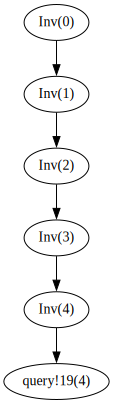

In [27]:
sp = SpacerProof(answer)
sp

The shortest counter-example is to start the counter at `0` and count until `4`, at which point the bad state is reached.

## Principle of Backward Induction

Sometimes forward induction is not effective. One alternative is to run the analysis backwards.
A counter-example starts from a bad state and goes towards initial state. There is no need to change the
underlying sat algorithm for that. We simply change the encoding!

A **backward inductive invariant** for $P = (V, Init, Tr, Bad)$ is a formula $BInv$ such that 
   
  1. $Bad \implies BInv$
  2. $BInv' \wedge Tr \implies Binv$
  3. $BInv \wedge Init \implies False$
    
**Fact**: If $BInv$ is a backward inductive invariant for $P$, then $\neg BInv$ is an inductive invariant for $P$.

In [28]:
def vc_gen_bwd(T):
    '''Verification Condition (VC) for Backward Inductive Invariant'''

    Inv = z3.Function('BwdInv', *(T.sig() + [z3.BoolSort()]))

    InvPre = Inv(*T.pre_vars())
    InvPost = Inv(*T.post_vars())

    all_vars = T.all()
    vc_init = z3.ForAll(all_vars, z3.Implies(T.Bad, InvPre))
    vc_ind = z3.ForAll(all_vars, z3.Implies(z3.And(InvPost, T.Tr), InvPre))
    vc_bad = z3.ForAll(all_vars, z3.Implies(z3.And(InvPre, T.Init), z3.BoolVal(False)))

    return [vc_init, vc_ind, vc_bad], InvPre

In [29]:
ts0 = mk_ts0(safe=True)
vc, inv = vc_gen_bwd(ts0)
chc_to_str(vc)

"&forall;x, x' : x &ge; 10 &rArr; BwdInv(x) <br/><br/>&forall;x, x' : BwdInv(x') &and; x &lt; 5 &and; x' = x + 1 &rArr; BwdInv(x) <br/><br/>&forall;x, x' : BwdInv(x) &and; x &le; 0 &rArr; False <br/><br/>"

In [30]:
res, answer = solve_horn(vc)
answer.eval(inv)

&not;(x &le; 9)

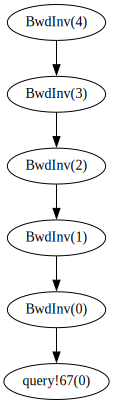

In [31]:
ts0 = mk_ts0(safe=False)
vc, inv = vc_gen_bwd(ts0)
res, answer = solve_horn(vc)
SpacerProof(answer)

As expected, the counter-example runs backward. Starting fromt the bad state and evolving to the initial state.

## The principle of 2-induction

2-induction, or more generally, $k$-induction is a strengthening of the principle of induction. It allows assuming inductive hypothesis for multiple steps of the transtion relation.

A **2-inductive invariant** for a system $P = (V, Init, Tr, Bad)$ is a formula $2Inv$ such that

   1. (initiataion 1) $Init \implies 2Inv$
   2. (initiation 2)  $Init \wedge Tr \implies 2Inv'$
   3. (2-induction)   $2Inv \wedge Tr \wedge 2Inv' \wedge Tr' \implies 2Inv''$
   4. (safety)        $2Inv \wedge Bad \implies False$
   
Fromt the above definition, it is obvious that discovering a 2-inductive hypothesis is reducible to satisfiablity of *non-linear* CHC.

In [32]:
# helper function to compute sequential composition by connecting output of T1 to input of T2
def mk_seq(T1, T2, constraint = None):
    """
    Constructs a sequential composition of two transition systems.

    An optional constraint is added on the glue variables of the composition.
    The constraint must be specified over pre-state variables of T1
    """
    assert len(T1.post_vars()) == len(T2.post_vars())
    assert len(T1.inputs()) == 0, "Not supported yet"
    assert len(T2.inputs()) == 0, "Not supported yet"

    for v1, v2 in zip(T1.post_vars(), T2.pre_vars()):
        assert(v1.sort() == v2.sort())

    TSeq = Ts(T1.name + ';' + T2.name)
    for idx, v in enumerate(T1.pre_vars()):
        TSeq.add_var(v.sort(), T1.get_var_name(idx))

    glue = [TSeq.add_input(v.sort()) for v in T1.post_vars()]
    Tr1 = z3.substitute(T1.Tr, *list(zip(T1.post_vars(), glue)))
    Tr2 = z3.substitute(T2.Tr, *list(zip(T2.pre_vars(), glue)))

    # if there is an optional constraint, shift it to the glue variables
    C = z3.BoolVal(True)
    if constraint is not None:
       C = z3.substitute(constraint, *list(zip(T1.pre_vars(), glue)))

    TSeq.Tr = z3.simplify(z3.And(Tr1, Tr2, C))

    TSeq.Init = T1.Init
    TSeq.Bad = T2.Bad

    return TSeq

def vc_gen_2ind(T):
    """Verification condition for 2-inductive invariant"""
    Inv = z3.Function('2Inv', *(T.sig() + [z3.BoolSort()]))

    InvPre = Inv(*T.pre_vars())
    InvPost = Inv(*T.post_vars())

    all_vars = T.all()
    # Inv contains initial states
    vc_init1 = z3.ForAll(all_vars, z3.Implies(T.Init, InvPre))
    # Inv contains states reachable in one step
    vc_init2 = z3.ForAll(all_vars, z3.Implies(z3.And(T.Init, T.Tr), InvPost))

    # Inv is stable under two steps of Tr , assuming Inv holds after first step
    TSeq = mk_seq(T, T, constraint = InvPre)
    InvPost = Inv(*TSeq.post_vars())
    all_vars = TSeq.all()
    vc_ind = z3.ForAll(all_vars, z3.Implies(z3.And(InvPre, TSeq.Tr), InvPost))

    # Inv does not satisfy Bad
    vc_bad = z3.ForAll(all_vars, z3.Implies(z3.And(InvPre, T.Bad), z3.BoolVal(False)))

    return [vc_init1, vc_init2, vc_ind, vc_bad], InvPre

In [33]:
ts0 = mk_ts0(safe=True)
vc, inv = vc_gen_2ind(ts0)
chc_to_str(vc)

"&forall;x, x' : x &le; 0 &rArr; 2Inv(x) <br/><br/>&forall;x, x' : x &le; 0 &and; x &lt; 5 &and; x' = x + 1 &rArr; 2Inv(x') <br/><br/>&forall;x, x', i_0 :<br/> 2Inv(x) &and;<br/> &not;(5 &le; x) &and;<br/> i_0 = 1 + x &and;<br/> &not;(5 &le; i_0) &and;<br/> x' = 1 + i_0 &and;<br/> 2Inv(i_0) &rArr;<br/> 2Inv(x') <br/><br/>&forall;x, x', i_0 : 2Inv(x) &and; x &ge; 10 &rArr; False <br/><br/>"

In [34]:
res, answer = solve_horn(vc)
answer.eval(inv)

&not;(x &ge; 6)

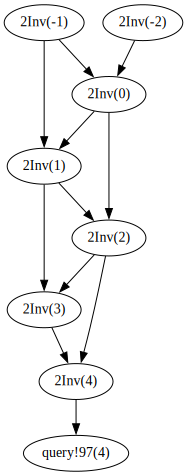

In [35]:
ts0 = mk_ts0(safe=False)
vc, inv = vc_gen_2ind(ts0)
res, answer = solve_horn(vc)
SpacerProof(answer)

Spacer often finds the shortest counterexample. The counterexample above is short (4 transitions), but maybe not the most obvious one.

## Control Flow Automaton (CFA)

It is often desired to extend a transition system with control locations. 
A **Control Flow Automaton (CFA)** is a graph 
$G = (V, E, entry, exit, \tau)$, where

  1. $V$ is a set of control locations
  2. $E \subseteq V \times V$ is a set of control flow edges
  3. $entry \in V$, $exit \in V$ are designated *entry* and *exit* locations
  4. $\tau : E \to Tr$ maps each edge in $E$ to a transition relation
  
A CFA $A$ is **SAFE** if there is no path $\pi$ from $entry$ to $exit$ that each edge on $\pi$ satisfies the corresponding transition relation.

A CFA $A$ is **SAFE** if and only iff there exists an **inductive invariant map** $\sigma : V \to Fml$ such that 

   1. (initiation) $\sigma(entry) = True$
   2. (safety) $\sigma(exit) = False$
   3. (induction) for every edge $(u, v) \in E$, $\sigma(u) \wedge \tau(u, v) \implies \sigma(v)'$

We begin by defining a python class to represent a CFA:

In [36]:
class CFA(object):
    '''Control Flow Automaton

    An automation whose nodes are annotated with transition relations
    '''
    def __init__(self, name):
        self._base = Ts(name)

        self.entry = None
        self.exit = None
        self.edges = dict()
        self.nodes = set()
    def sig(self):
        return self._base.sig()
    def inputs(self):
        return self._base.inputs()
    def pre_vars(self):
        return self._base.pre_vars()
    def post_vars(self):
        return self._base.post_vars()
    def vars(self):
        return self._base.vars()
    def pre_post_vars(self):
        return self._base.pre_post_vars()
    def all(self):
        return self._base.all()
    def add_var(self, sort, name=None):
        return self._base.add_var(sort, name)
    def add_input(self, sort, name=None):
        return self._base.add_input(sort, name)
    def to_post(self, e):
        return self._base.to_post(e)
    def add_edge(self, src, dst, tr):
        self.nodes.add(src)
        self.nodes.add(dst)
        self.edges[(src, dst)] = tr
    def set_entry_node(self, n):
        self.nodes.add(n)
        self.entry = n
    def set_exit_node(self, n):
        self.nodes.add(n)
        self.exit = n
    def is_entry_node(self, n):
        return n == self.entry
    def is_exit_node(self, n):
        return n == self.exit

    def to_dot(self):
        import graphviz
        g = graphviz.Digraph()

        for n in self.nodes:
            g.node(str(n), str(n))

        for (k, v) in self.edges.items():
            src, dst = k
            g.edge(str(src), str(dst), label=str(v))

        return g

Then, convert our running example to a CFA:

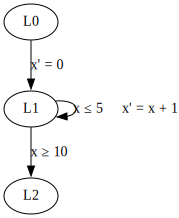

In [37]:
def mk_cfa0(safe=True):
    A = CFA('prog')
    x, x_out = A.add_var(z3.IntSort(), name='x')

    A.add_edge('L0', 'L1', x_out == 0)
    A.add_edge('L1', 'L1', z3.And(x <= 5, x_out == x + 1))
    if safe:
        A.add_edge('L1', 'L2', x >= 10)
    else:
        A.add_edge('L1', 'L2', x >= 4)

    A.set_entry_node('L0')
    A.set_exit_node('L2')
    return A
cfa0 = mk_cfa0(safe=True)
cfa0.to_dot()

To compute an inductive map, we define a CHC system with one uninterpreted predicate per control location. In our running example above, we will have 3 predicates representing invariants at location $L_0$, $L_1$, and $L_2$, respectively:

In [38]:
def cfa_vc_gen(A):
    '''Verification Condition (VC) for a Control Flow Automaton'''
    all_vars = A.all()
    sig = A.sig() + [z3.BoolSort()]

    Invs = dict()
    for n in A.nodes:
        inv = z3.Function(str(n), *sig)
        Invs[n] = inv

    Entry = Invs[A.entry]
    Exit = Invs[A.exit]

    vc = list()
    vc.append(z3.ForAll(all_vars, Entry(*A.pre_vars())))

    for (k, v) in A.edges.items():
        src, dst = k
        srcP, dstP = Invs[src], Invs[dst]

        head = dstP(*A.post_vars())
        sPred = srcP(*A.pre_vars())
        vc.append(z3.ForAll(all_vars, z3.Implies(z3.And(sPred, v), head)))
    vc.append(z3.ForAll(all_vars,
                        z3.Implies(Exit(*A.pre_vars()), z3.BoolVal(False))))
    return vc, {n : Invs[n](A.pre_vars()) for n in A.nodes}

In [39]:
chc, invs = cfa_vc_gen(cfa0)
chc_to_str(chc)

"&forall;x, x' : L0(x) <br/><br/>&forall;x, x' : L0(x) &and; x' = 0 &rArr; L1(x') <br/><br/>&forall;x, x' : L1(x) &and; x &le; 5 &and; x' = x + 1 &rArr; L1(x') <br/><br/>&forall;x, x' : L1(x) &and; x &ge; 10 &rArr; L2(x') <br/><br/>&forall;x, x' : L2(x) &rArr; False <br/><br/>"

In [40]:
res, answer = solve_horn(chc)
res

<b>sat</b>

In [41]:
invs

{'L1': L1(x), 'L2': L2(x), 'L0': L0(x)}

In [42]:
answer.eval(invs['L0'])

True

In [43]:
answer.eval(invs['L1'])

&not;(x &ge; 7)

In [44]:
answer.eval(invs['L2'])

False

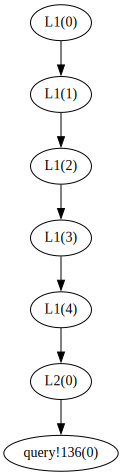

In [45]:
cfa0 = mk_cfa0(safe=False)
vc, invs = cfa_vc_gen(cfa0)
res, answer = solve_horn(vc)
SpacerProof(answer)

## Arrays and Quantifiers

So far, we have only used integer valued state variables. Other sorts and theories are supported as well. For example, we can use array-valued state variables to represent a state of computer memory:

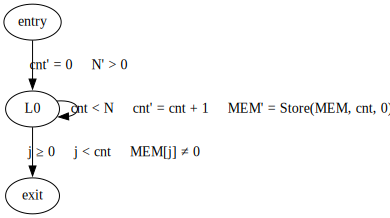

In [46]:
def mk_cfa1():
    A = CFA('prog2')
    ZZ = z3.IntSort()
    Mem, Mem_out = A.add_var(z3.ArraySort(ZZ, ZZ), name='MEM')
    N, N_out = A.add_var(ZZ, name='N')
    cnt, cnt_out = A.add_var(ZZ, name='cnt')
    # local variable
    j = A.add_input(ZZ, name='j')

    # initially counter is 0, N is positive
    init_tr = z3.And(cnt_out == 0, N_out > 0)
    A.add_edge('entry', 'L0', init_tr)

    # if cnt < N then Mem[cnt++] := 0
    loop_tr = z3.And(cnt < N,
                     cnt_out == cnt + 1,
                     Mem_out == z3.Update(Mem, cnt,  0))
    A.add_edge('L0', 'L0', loop_tr)

    # if 0 <= j < cnt then assert(Mem[j] == 0)
    bad_tr = z3.And(0 <= j, j < cnt, Mem[j] != 0)
    A.add_edge('L0', 'exit', bad_tr)

    A.set_entry_node('entry')
    A.set_exit_node('exit')
    return A
cfa1 = mk_cfa1()
cfa1.to_dot()

In [47]:
vc, invs = cfa_vc_gen(cfa1)
res, answer = solve_horn(vc)
res

<b>unknown</b>

No solution is found (with out search limit). The underlying reason is that so far we have been restricted to quantifier free solutions. Yet, no QF solution exists for this problem.

In [48]:
res, answer = solve_horn(vc, q3=True)
res

<b>sat</b>

In [49]:
answer.eval(invs['L0'])

(&forall;sk!0 :
  &not;(MEM[sk!0] &le; -1) &or; &not;(sk!0 + -1&middot;cnt &le; -1) &or; &not;(sk!0 &ge; 0)) &and;
(&forall;sk!0 :
  &not;(sk!0 &ge; 0) &or; &not;(MEM[sk!0] &ge; 1) &or; &not;(sk!0 + -1&middot;cnt &le; -1))

The solution above is a little hard to read, but it is equivalent to the expected result:

$\forall sk \cdot 0 \leq sk < cnt \implies MEM[sk] \leq 0$ <br/>
$\forall sk \cdot 0 \leq sk < cnt \implies MEM[sk] \geq 0$

## Lamport's Bakery Algorithm

It is common for multiple processes to share the same resources in concurrent systems. Lamport's Bakery Algorithm facilitates this sharing and seeks to prevent multiple processes from accessing the critical sections of code at the same time.

We can encode a transition system for Bakery, where

1. *Issue* is the next priority to be issued
2. *Serve* is the process currently being served
3. *State* is an array of the state for each process, where *0* is idle, *1* is waiting to be served, and *2* is being served
4. *Num* is an array of the priority for each process

Here we have restricted the implementation to 3 processes: 1, 2, and 3.

In [50]:
def mk_bakery():
    T = Ts('Bakery')
    ZZ = z3.IntSort()
    State, State_out = T.add_var(z3.ArraySort(ZZ,ZZ), name='State')
    Num, Num_out = T.add_var(z3.ArraySort(ZZ,ZZ), name='Num')
    Issue, Issue_out = T.add_var(ZZ, name='Issue')
    Serve, Serve_out = T.add_var(ZZ, name='Serve')
    i = T.add_input(ZZ, name='i')
    j = T.add_input(ZZ, name='j')
    
    T.Init = z3.And(Issue == 0, Serve == 0, State[1] == 0, State[2] == 0, State[3] == 0, Num[1] == -1, Num[2] == -1, Num[3] == -1)
    T.Tr = z3.Or(
                    z3.And(
                        State[i] == 0,
                        i <= 3,
                        i >= 1,
                        Serve_out == Serve,
                        Issue_out == Issue + 1,
                        State_out == z3.Update(State, i,  1),
                        Num_out == z3.Update(Num, i, Issue)),
                    z3.And(
                        State[i] == 1,
                        i <= 3, 
                        i >= 1,
                        Num[i] == Serve,
                        Serve_out == Serve,
                        Issue_out == Issue,
                        Num_out == Num,
                        State_out == z3.Update(State, i,  2)),
                    z3.And(
                        State[i] == 2,
                        i <= 3,
                        i >= 1,
                        Issue_out == Issue,
                        Serve_out == Serve + 1,
                        Num_out == z3.Update(Num, i, -1),
                        State_out == z3.Update(State, i,  0))
    )
    T.Bad = z3.And(State[i] == 2, State[j] == 2, i != j, i <= 3, i >= 1, j <= 3, j >= 1)
    return T
bakery = mk_bakery()
HtmlStr(bakery)

"Transition System: Bakery<br/>\tInit: Issue = 0 &and;<br/>Serve = 0 &and;<br/>State[1] = 0 &and;<br/>State[2] = 0 &and;<br/>State[3] = 0 &and;<br/>Num[1] = -1 &and;<br/>Num[2] = -1 &and;<br/>Num[3] = -1<br/>\tBad: State[i] = 2 &and;<br/>State[j] = 2 &and;<br/>i &ne; j &and;<br/>i &le; 3 &and;<br/>i &ge; 1 &and;<br/>j &le; 3 &and;<br/>j &ge; 1<br/>\tTr: State[i] = 0 &and;<br/>i &le; 3 &and;<br/>i &ge; 1 &and;<br/>Serve' = Serve &and;<br/>Issue' = Issue + 1 &and;<br/>State' = Store(State, i, 1) &and;<br/>Num' = Store(Num, i, Issue) &or;<br/>State[i] = 1 &and;<br/>i &le; 3 &and;<br/>i &ge; 1 &and;<br/>Num[i] = Serve &and;<br/>Serve' = Serve &and;<br/>Issue' = Issue &and;<br/>Num' = Num &and;<br/>State' = Store(State, i, 2) &or;<br/>State[i] = 2 &and;<br/>i &le; 3 &and;<br/>i &ge; 1 &and;<br/>Issue' = Issue &and;<br/>Serve' = Serve + 1 &and;<br/>Num' = Store(Num, i, -1) &and;<br/>State' = Store(State, i, 0)"

In [51]:
vc, inv = vc_gen(bakery)
chc_to_str(vc)

"&forall;State,<br/> Num,<br/> Issue,<br/> Serve,<br/> State',<br/> Num',<br/> Issue',<br/> Serve',<br/> i,<br/> j :<br/> Issue = 0 &and;<br/> Serve = 0 &and;<br/> State[1] = 0 &and;<br/> State[2] = 0 &and;<br/> State[3] = 0 &and;<br/> Num[1] = -1 &and;<br/> Num[2] = -1 &and;<br/> Num[3] = -1 &rArr;<br/> Inv(State, Num, Issue, Serve) <br/><br/>&forall;State,<br/> Num,<br/> Issue,<br/> Serve,<br/> State',<br/> Num',<br/> Issue',<br/> Serve',<br/> i,<br/> j :<br/> Inv(State, Num, Issue, Serve) &and;<br/> (State[i] = 0 &and;<br/>  i &le; 3 &and;<br/>  i &ge; 1 &and;<br/>  Serve' = Serve &and;<br/>  Issue' = Issue + 1 &and;<br/>  State' = Store(State, i, 1) &and;<br/>  Num' = Store(Num, i, Issue) &or;<br/>  State[i] = 1 &and;<br/>  i &le; 3 &and;<br/>  i &ge; 1 &and;<br/>  Num[i] = Serve &and;<br/>  Serve' = Serve &and;<br/>  Issue' = Issue &and;<br/>  Num' = Num &and;<br/>  State' = Store(State, i, 2) &or;<br/>  State[i] = 2 &and;<br/>  i &le; 3 &and;<br/>  i &ge; 1 &and;<br/>  Issue' = Issue &and;<br/>  Serve' = Serve + 1 &and;<br/>  Num' = Store(Num, i, -1) &and;<br/>  State' = Store(State, i, 0)) &rArr;<br/> Inv(State', Num', Issue', Serve') <br/><br/>&forall;State,<br/> Num,<br/> Issue,<br/> Serve,<br/> State',<br/> Num',<br/> Issue',<br/> Serve',<br/> i,<br/> j :<br/> Inv(State, Num, Issue, Serve) &and;<br/> State[i] = 2 &and;<br/> State[j] = 2 &and;<br/> i &ne; j &and;<br/> i &le; 3 &and;<br/> i &ge; 1 &and;<br/> j &le; 3 &and;<br/> j &ge; 1 &rArr;<br/> False <br/><br/>"

In [52]:
res, answer = solve_horn(vc, q3=False, max_unfold=100)
HtmlStr(res)

'<b>sat</b>'

In [53]:
horn_inv = answer.eval(inv)
for f in horn_inv.children():
    display(f)

&not;(State[1] &ge; 1) &or;
&not;(State[2] &ge; 1) &or;
&not;(Serve + -1&middot;Num[1] &le; -2) &or;
&not;(State[3] &ge; 1) &or;
&not;(Serve + -1&middot;Issue &ge; -2)

&not;(State[2] &ge; 2) &or; &not;(State[3] &ge; 2)

&not;(Serve + -1&middot;Issue &ge; 0) &or; &not;(State[3] &ge; 2)

&not;(State[1] &ge; 2) &or; &not;(State[2] &ge; 2)

&not;(State[1] &ge; 2) &or; &not;(State[3] &ge; 2)

&not;(State[2] &ge; 2) &or; &not;(Serve + -1&middot;Issue &ge; 0)

&not;(State[1] &ge; 2) &or; &not;(Serve + -1&middot;Issue &ge; 0)

&not;(State[2] &ge; 1) &or; &not;(State[3] &ge; 2) &or; &not;(Num[2] = Serve)

&not;(State[3] &ge; 1) &or; &not;(State[1] &ge; 2) &or; &not;(Num[3] = Serve)

&not;(State[3] &ge; 1) &or;
&not;(Serve + -1&middot;Issue &ge; 0) &or;
&not;(Serve + -1&middot;Num[3] &le; 0)

&not;(State[2] &ge; 1) &or;
&not;(Serve + -1&middot;Issue &ge; 0) &or;
&not;(Serve + -1&middot;Num[2] &le; 0)

&not;(State[2] &ge; 1) &or;
&not;(State[3] &ge; 1) &or;
&not;(Num[2] = Serve) &or;
&not;(Num[3] = Serve)

&not;(State[3] &ge; 1) &or; &not;(State[2] &ge; 2) &or; &not;(Num[3] = Serve)

&not;(Serve + -1&middot;Num[1] &le; 0) &or;
&not;(State[1] &ge; 1) &or;
&not;(Serve + -1&middot;Issue &ge; 0)

&not;(State[1] &ge; 1) &or;
&not;(Num[1] = Serve) &or;
&not;(State[2] &ge; 1) &or;
&not;(Num[2] = Serve)

&not;(State[2] &ge; 1) &or; &not;(State[1] &ge; 2) &or; &not;(Num[2] = Serve)

&not;(State[1] &ge; 1) &or;
&not;(State[3] &ge; 1) &or;
&not;(Serve + -1&middot;Issue &ge; -1) &or;
&not;(Serve + -1&middot;Num[3] &le; -1)

&not;(Serve + -1&middot;Num[2] = -1) &or;
&not;(State[2] &ge; 1) &or;
&not;(Serve + -1&middot;Num[3] = -1) &or;
&not;(State[3] &ge; 1) &or;
&not;(State[1] &ge; 2)

&not;(State[1] &ge; 1) &or;
&not;(Num[1] = Serve) &or;
&not;(State[3] &ge; 1) &or;
&not;(Num[3] = Serve)

&not;(Serve + -1&middot;Num[2] = -1) &or;
&not;(State[1] &ge; 1) &or;
&not;(Serve + -1&middot;Num[1] &ge; 0) &or;
&not;(State[2] &ge; 1) &or;
&not;(Serve + -1&middot;Num[3] = -1) &or;
&not;(State[3] &ge; 1)

&not;(Serve + -1&middot;Num[2] = -1) &or;
&not;(Serve + -1&middot;Num[1] = -1) &or;
&not;(State[1] &ge; 1) &or;
&not;(State[2] &ge; 1) &or;
&not;(State[3] &ge; 2)

&not;(Num[1] = Serve) &or; &not;(State[1] &ge; 1) &or; &not;(State[2] &ge; 2)

&not;(Serve + -1&middot;Issue &ge; -1) &or;
&not;(Serve + -1&middot;Num[2] &le; -1) &or;
&not;(State[2] &ge; 1) &or;
&not;(State[3] &ge; 1)

&not;(Serve + -1&middot;Issue &ge; -1) &or;
&not;(State[1] &ge; 1) &or;
&not;(Serve + -1&middot;Num[2] &le; -1) &or;
&not;(State[2] &ge; 1)

&not;(State[2] &ge; 1) &or;
&not;(State[3] &ge; 1) &or;
&not;(Serve + -1&middot;Issue &ge; -1) &or;
&not;(Serve + -1&middot;Num[3] &le; -1)

&not;(Serve + -1&middot;Issue &ge; -1) &or;
&not;(State[1] &ge; 1) &or;
&not;(State[2] &ge; 1) &or;
&not;(Serve + -1&middot;Num[1] &le; -1)

&not;(Serve + -1&middot;Issue &ge; -1) &or;
&not;(State[1] &ge; 1) &or;
&not;(State[3] &ge; 1) &or;
&not;(Serve + -1&middot;Num[1] &le; -1)

&not;(Serve + -1&middot;Num[1] = -1) &or;
&not;(State[1] &ge; 1) &or;
&not;(State[2] &ge; 1) &or;
&not;(Serve + -1&middot;Num[3] = -1) &or;
&not;(Serve + -1&middot;Num[2] &ge; 0) &or;
&not;(State[3] &ge; 1)

&not;(Serve + -1&middot;Num[1] = -1) &or;
&not;(State[1] &ge; 1) &or;
&not;(Serve + -1&middot;Num[3] = -1) &or;
&not;(State[3] &ge; 1) &or;
&not;(State[2] &ge; 2)

&not;(Serve + -1&middot;Num[3] &le; -2) &or;
&not;(State[1] &ge; 1) &or;
&not;(State[2] &ge; 1) &or;
&not;(State[3] &ge; 1) &or;
&not;(Serve + -1&middot;Issue &ge; -2)

&not;(State[1] &ge; 1) &or; &not;(State[3] &ge; 2) &or; &not;(Serve + -1&middot;Num[1] = 0)

&not;(Serve + -1&middot;Num[3] &ge; 0) &or;
&not;(Serve + -1&middot;Num[2] = -1) &or;
&not;(Serve + -1&middot;Num[1] = -1) &or;
&not;(State[1] &ge; 1) &or;
&not;(State[2] &ge; 1) &or;
&not;(State[3] &ge; 1)

&not;(State[1] &ge; 1) &or;
&not;(Serve + -1&middot;Num[2] &le; -2) &or;
&not;(State[2] &ge; 1) &or;
&not;(State[3] &ge; 1) &or;
&not;(Serve + -1&middot;Issue &ge; -2)

We can condense and display this in SMT-LIB format.

In [54]:
s = z3.SolverFor('HORN')
s.add(vc)
print('(set-logic HORN)')
print(s.sexpr())
print('(check-sat)')

(set-logic HORN)
(declare-fun Inv ((Array Int Int) (Array Int Int) Int Int) Bool)
(assert (forall ((State (Array Int Int))
         (Num (Array Int Int))
         (Issue Int)
         (Serve Int)
         (|State'| (Array Int Int))
         (|Num'| (Array Int Int))
         (|Issue'| Int)
         (|Serve'| Int)
         (i Int)
         (j Int))
  (=> (and (= Issue 0)
           (= Serve 0)
           (= (select State 1) 0)
           (= (select State 2) 0)
           (= (select State 3) 0)
           (= (select Num 1) (- 1))
           (= (select Num 2) (- 1))
           (= (select Num 3) (- 1)))
      (Inv State Num Issue Serve))))
(assert (forall ((State (Array Int Int))
         (Num (Array Int Int))
         (Issue Int)
         (Serve Int)
         (|State'| (Array Int Int))
         (|Num'| (Array Int Int))
         (|Issue'| Int)
         (|Serve'| Int)
         (i Int)
         (j Int))
  (let ((a!1 (or (and (= (select State i) 0)
                      (<= i 3)
              

## Back to basics

CHC Satisfiability over Linear Integer Arithmetic is undecidable. Thus, there are always "simple looking" instances that are difficult to solve with any current algorithm. In this part of the tutorial, we will look at how different encoding techniques are used to guide the search.

## Predicate Abstraction

(Implicit) Predicate Abstraction is an abstraction (or search guidance) technique that restricts the search to a solution that is expressed by a Boolean combination of a user-defined set of predicates.

Given a set of predicates $Pred$ (i.e., formulas in the underlying theory), a predicate abstraction of an inductive invariant for a transition system $P$ is a formula $InvPred$ such that
  1. $InvPred$ is a Boolean combination of predicates from $Pred$
  2. $InvPred$ is an inductive invariant of $P$
  
Note that deciding whether there exists an $InvPred$ is **decidable**! There are finitely many distinct Boolean combinations of a given finite set of predicates.

[CGMT14] A. Cimatti, A. Griggio, S. Mover, S. Tonetta:
_IC3 Modulo Theories via Implicit Predicate Abstraction_. TACAS 2014: 46-61


In [55]:
def mk_ts1(safe=True):
    T = Ts('Ts1')
    a, a_out = T.add_var(z3.IntSort(), name='a')
    b, b_out = T.add_var(z3.IntSort(), name='b')
    c, c_out = T.add_var(z3.IntSort(), name='c')
    T.Init = z3.And(a == 0, 0 < c, c < 5, b == 3 * c)
    T.Tr = z3.And(a < 200, a_out == a + 1, b_out == b + 1)
    if safe:
        T.Bad = z3.Not(z3.And(3 <= b, b <= 200 + 12))
    else:
        T.Bad = z3.Not(z3.And(3 <= b, b <= 200 + 2))
    return T
ts1 = mk_ts1(safe=True)
HtmlStr(ts1)

"Transition System: Ts1<br/>\tInit: a = 0 &and; c &gt; 0 &and; c &lt; 5 &and; b = 3&middot;c<br/>\tBad: &not;(b &ge; 3 &and; b &le; 212)<br/>\tTr: a &lt; 200 &and; a' = a + 1 &and; b' = b + 1"

In [52]:
vc, inv = vc_gen(ts1)
res, answer = solve_horn(vc)
res

<b>unknown</b>

We define `vc_gen_pa` that generates verification condition for predicate abstraction given a set of predicates. The basic structure is the same as `vc_gen`, except, the uninterpreted predicate `InvPredAbs` only takes Boolean arguments. The predicates are evaluated in the pre-state and post-state of the transition relation, and are then passed to `InvPredAbs`.

In [56]:
def vc_gen_pa(T, preds):
    '''Verification Condition for Predicate Abstraction'''

    post_preds = [T.to_post(p) for p in preds]

    # create predicate Inv
    sig = [z3.BoolSort()] * (len(preds) + 1)
    Inv = z3.Function('InvPredAbs', *sig)

    all_vars = T.all()

    InvPre = Inv(*preds)
    InvPost = Inv(*post_preds)
    vc_init = z3.ForAll(all_vars, z3.Implies(T.Init, InvPre))
    vc_ind = z3.ForAll(all_vars, z3.Implies(z3.And(InvPre, T.Tr), InvPost))
    vc_bad = z3.ForAll(all_vars,
                       z3.Implies(z3.And(InvPre, T.Bad), z3.BoolVal(False)))

    return [vc_init, vc_ind, vc_bad], InvPre

In [57]:
a = ts1.get_pre_var('a')
b = ts1.get_pre_var('b')
vc, inv = vc_gen_pa(ts1, [b - a >= 13, a >= 0, b <= 2, b >= 213])

In [58]:
chc_to_str(vc)

"&forall;a, b, c, a', b', c' :<br/> a = 0 &and; c &gt; 0 &and; c &lt; 5 &and; b = 3&middot;c &rArr;<br/> InvPredAbs(b - a &ge; 13, a &ge; 0, b &le; 2, b &ge; 213) <br/><br/>&forall;a, b, c, a', b', c' :<br/> InvPredAbs(b - a &ge; 13, a &ge; 0, b &le; 2, b &ge; 213) &and;<br/> a &lt; 200 &and;<br/> a' = a + 1 &and;<br/> b' = b + 1 &rArr;<br/> InvPredAbs(b' - a' &ge; 13, a' &ge; 0, b' &le; 2, b' &ge; 213) <br/><br/>&forall;a, b, c, a', b', c' :<br/> InvPredAbs(b - a &ge; 13, a &ge; 0, b &le; 2, b &ge; 213) &and;<br/> &not;(b &ge; 3 &and; b &le; 212) &rArr;<br/> False <br/><br/>"

In [59]:
res, answer = solve_horn(vc)
res

<b>sat</b>

In [60]:
answer.eval(inv)

&not;(b &ge; 213) &and; &not;(b &le; 2) &and; a &ge; 0 &and; &not;(b + -1&middot;a &ge; 13)

## Term Abstraction

Predicate abstraction requires the user to specify the exact predicates to be used in the solution.
We can relax this by requiring the user to only specify the terms that are allowed in the solution.

Predicate Abstraction is a special case of Term Abstraction where user provided terms are Boolean.

[LRS16] J. Leroux, P. Rümmer, P. Subotic:
_Guiding Craig interpolation with domain-specific abstractions_. Acta Inf. 53(4): 387-424 (2016)


In [61]:
def vc_gen_ta(T, terms):
    '''Verification Condition for Term Abstraction'''

    post_terms = [T.to_post(p) for p in terms]

    # create term Inv
    sig = [t.sort() for t in terms] + [z3.BoolSort()]
    Inv = z3.Function('InvTermAbs', *sig)
    all_vars = T.all()

    InvPre = Inv(*terms)
    InvPost = Inv(*post_terms)

    vc_init = z3.ForAll(all_vars, z3.Implies(T.Init, InvPre))
    vc_ind = z3.ForAll(all_vars, z3.Implies(z3.And(InvPre, T.Tr), InvPost))
    vc_bad = z3.ForAll(all_vars,
                       z3.Implies(z3.And(InvPre, T.Bad), z3.BoolVal(False)))

    return [vc_init, vc_ind, vc_bad], InvPre

In [62]:
a, b, c = ts1.get_pre_vars('a b c')
vc, inv = vc_gen_ta(ts1, [b-a, b])
res, answer = solve_horn(vc, max_unfold=400)
res

<b>sat</b>

In [63]:
answer.eval(inv)

&not;(a &le; -1) &and; &not;(b + -1&middot;a &ge; 13) &and; &not;(b &ge; 213) &and; &not;(b &le; 2)

## Invariant Partitioning

Another way to guide the search is to look for modular invariants. The state variables are partitioned into groups $G_1$, $G_2$, ..., The invariant is partitioned into a conjunction of formulas $Inv_1$, $Inv_2$, ... such that $Inv_i$ is a formula over state variables in group $G_i$. Note that the groups $G_i$ do not have to be disjoint.

In [64]:
def vc_gen_part(T, partitions):
    '''Partitioned abstraction'''

    def _mk_inv_pred(name, vars):
        sig = [v.sort() for v in vars] + [z3.BoolSort()]
        inv = z3.Function(name, *sig)
        return inv(vars)

    part_inv = [_mk_inv_pred('PartInv_' + str(pname), vars)
                for pname, vars in partitions.items()]


    vc = list()
    all_vars = T.all()
    for inv in part_inv:
        vc.append(z3.ForAll(all_vars, z3.Implies(T.Init, inv)))

    preInvs = z3.And(part_inv)
    for inv in part_inv:
        postInv = T.to_post(inv)
        vc.append(z3.ForAll(all_vars,
                            z3.Implies(z3.And(preInvs, T.Tr),
                                       postInv)))
    vc.append(z3.ForAll(all_vars,
                        z3.Implies(z3.And(preInvs, T.Bad),
                                   z3.BoolVal(False))))
    return vc, preInvs

In [65]:
def mk_ts2():
    T = Ts('Ts2')
    a, a_out = T.add_var(z3.IntSort(), name='a')
    b, b_out = T.add_var(z3.IntSort(), name='b')
    c, c_out = T.add_var(z3.IntSort(), name='c')
    d, d_out = T.add_var(z3.IntSort(), name='d')
    T.Init = z3.And(a == 0, b == 0, c == 0, d == 0)
    T.Tr = z3.And(a_out == a + 1,
                  b_out == b + a + 1,
                  c_out == c + b + a + 1,
                  d_out == d + c + b + a + 1)
    T.Bad = z3.Not(d >= 0)
    return T
ts2 = mk_ts2()
HtmlStr(ts2)

"Transition System: Ts2<br/>\tInit: a = 0 &and; b = 0 &and; c = 0 &and; d = 0<br/>\tBad: &not;(d &ge; 0)<br/>\tTr: a' = a + 1 &and;<br/>b' = b + a + 1 &and;<br/>c' = c + b + a + 1 &and;<br/>d' = d + c + b + a + 1"

In [66]:
vc, inv = vc_gen(ts2)
res, answer = solve_horn(vc)
HtmlStr(res)

'<b>unknown</b>'

In [67]:
def mk_bnd(T, N):
    """
    Bound a given transition system by to at most N iterations

    Transforms a given transition system T into a transition system T_N
    that executes for at most N steps
    """

    import copy
    TN = copy.deepcopy(T)
    TN.name += '_bnd_' + str(N)
    bnd, bnd_out = TN.add_var(z3.IntSort(), "bnd")
    TN.Init = z3.simplify(z3.And(T.Init, bnd == N))
    TN.Tr = z3.simplify(z3.And(T.Tr, bnd_out < bnd, bnd_out >= 0))
    TN.Bad = T.Bad

    return TN
ts2_bnd = mk_bnd(ts2, N=4)
vc, inv = vc_gen(ts2_bnd)
res, answer = solve_horn(vc)
res

<b>sat</b>

In [68]:
HtmlStr(answer.eval(inv))

'&not;(bnd &ge; 5) &and;<br/>(&not;(bnd &ge; 2) &or; &not;(4&middot;a + 3&middot;b + d + 2&middot;c &le; -3)) &and;<br/>&not;(d &le; -1) &and;<br/>(&not;(bnd &ge; 1) &or; &not;(a + b + d + c &le; -1)) &and;<br/>(&not;(bnd &ge; 3) &or; &not;(10&middot;a + 6&middot;b + d + 3&middot;c &le; -11)) &and;<br/>(&not;(20&middot;a + 10&middot;b + d + 4&middot;c &le; -31) &or; &not;(bnd &ge; 4))'

The solver is stuck trying to find a monolithic solution that converges to an invariant in non-linear arithmetic!
We can guide it by partitioning the invariants to individual state variables:

In [69]:
def vc_gen_part(T, partitions):
    '''Partitioned abstraction'''

    def _mk_inv_pred(name, vars):
        sig = [v.sort() for v in vars] + [z3.BoolSort()]
        inv = z3.Function(name, *sig)
        return inv(vars)

    part_inv = [_mk_inv_pred('PartInv_' + str(pname), vars)
                for pname, vars in partitions.items()]


    vc = list()
    all_vars = T.all()
    for inv in part_inv:
        vc.append(z3.ForAll(all_vars, z3.Implies(T.Init, inv)))

    preInvs = z3.And(part_inv)
    for inv in part_inv:
        postInv = T.to_post(inv)
        vc.append(z3.ForAll(all_vars,
                            z3.Implies(z3.And(preInvs, T.Tr),
                                       postInv)))
    vc.append(z3.ForAll(all_vars,
                        z3.Implies(z3.And(preInvs, T.Bad),
                                   z3.BoolVal(False))))
    return vc, preInvs

a, b, c, d = ts2.get_pre_vars('a b c d')
vc, inv = vc_gen_part(ts2, { "a":[a], "b":[b], "c":[c], "d":[d] })
res, answer = solve_horn(vc)
res

<b>sat</b>

In [70]:
inv

PartInv_a(a) &and; PartInv_b(b) &and; PartInv_c(c) &and; PartInv_d(d)

In [71]:
answer.eval(inv)

&not;(a &le; -1) &and; &not;(b &le; -1) &and; &not;(c &le; -1) &and; &not;(d &le; -1)

In [72]:
vc, inv = vc_gen_part(ts2, { "ac":[a, c], "bc":[b, c], "d":[d] })
res, answer = solve_horn(vc)
answer.eval(inv)

&not;(c + a &le; -2) &and; &not;(a &le; -1) &and; &not;(b &le; -1) &and; &not;(d &le; -1)

In [73]:
chc_to_str(vc)

"&forall;a, b, c, d, a', b', c', d' :<br/> a = 0 &and; b = 0 &and; c = 0 &and; d = 0 &rArr; PartInv_ac(a, c) <br/><br/>&forall;a, b, c, d, a', b', c', d' :<br/> a = 0 &and; b = 0 &and; c = 0 &and; d = 0 &rArr; PartInv_bc(b, c) <br/><br/>&forall;a, b, c, d, a', b', c', d' :<br/> a = 0 &and; b = 0 &and; c = 0 &and; d = 0 &rArr; PartInv_d(d) <br/><br/>&forall;a, b, c, d, a', b', c', d' :<br/> PartInv_ac(a, c) &and;<br/> PartInv_bc(b, c) &and;<br/> PartInv_d(d) &and;<br/> a' = a + 1 &and;<br/> b' = b + a + 1 &and;<br/> c' = c + b + a + 1 &and;<br/> d' = d + c + b + a + 1 &rArr;<br/> PartInv_ac(a', c') <br/><br/>&forall;a, b, c, d, a', b', c', d' :<br/> PartInv_ac(a, c) &and;<br/> PartInv_bc(b, c) &and;<br/> PartInv_d(d) &and;<br/> a' = a + 1 &and;<br/> b' = b + a + 1 &and;<br/> c' = c + b + a + 1 &and;<br/> d' = d + c + b + a + 1 &rArr;<br/> PartInv_bc(b', c') <br/><br/>&forall;a, b, c, d, a', b', c', d' :<br/> PartInv_ac(a, c) &and;<br/> PartInv_bc(b, c) &and;<br/> PartInv_d(d) &and;<br/> a' = a + 1 &and;<br/> b' = b + a + 1 &and;<br/> c' = c + b + a + 1 &and;<br/> d' = d + c + b + a + 1 &rArr;<br/> PartInv_d(d') <br/><br/>&forall;a, b, c, d, a', b', c', d' :<br/> PartInv_ac(a, c) &and;<br/> PartInv_bc(b, c) &and;<br/> PartInv_d(d) &and;<br/> &not;(d &ge; 0) &rArr;<br/> False <br/><br/>"

## Combining Data Flow and Control Flow

Our examples so far modeled the control flow of the transition system. Alternatively,
we can model the data flow, and even combine the two together.

To model data flow, we extend our CFA with a block of _packed_ registers $p$ and two instructions:

  1. $pack (p := v)$ that stores the values of registers $v$ into the pack
  2. $unpack (v := p)$ that unpackes the values stored in $p$ into state registers $v$
  
Using $pack$ and $unpack$ we can model data flow (or, even weak memory updates)

In [74]:
class DCFA(CFA):
    def __init__(self, name):
        super().__init__(name)
        self._named_pack_vars = dict()
        self._pack_vars = list()
        self._pack_var_names = list()

    def all(self):
        return super().all() + self.pack_vars()
    def packed_sig(self):
        return [v.sort() for v in self._pack_vars]

    def add_pack_var(self, sort, name = None):
        vname = self._new_pack_var_name(name=name)
        v = z3.Const(vname, sort)
        self._pack_vars.append(v)
        self._pack_var_names.append(name)
        if name is not None:
            self._named_pack_vars[name] = v
        return v

    def get_pack_var(self, idx):
        if isinstance(idx, int):
            return self._pack_vars[idx]
        elif idx in self._named_pack_vars:
            return self._named_pack_vars[idx]
        return None

    def pack_vars(self):
        return self._pack_vars

    def get_pack_var_name(self, idx):
        if idx < len(self._pack_var_names):
            return self._pack_var_names[idx]
        return None

    def _new_pack_var_name(self, name):
        if name is not None:
            return str(name)
        else:
            idx = len(self._pack_vars)
            return 'p_' + str(idx)
        
class PackTr(object):
    "assignment of state/input expressions into packed variables"
    def __init__(self, *sub):
        self.sub = sub
    def __repr__(self):
        body = ' '.join([str(lhs) + ':=' + str(rhs) for (lhs, rhs) in self.sub])
        return 'pack(' + body + ')'

class UnpackTr(object):
    "assignment from packed variables to state/input variables"
    def __init__(self, *sub):
        self.sub = sub
    def __repr__(self):
        body = ' '.join([str(lhs) + ':=' + str(rhs) for (lhs, rhs) in self.sub])
        return 'unpack(' + body + ')'

In [75]:
def mk_dcfa0():
    A = DCFA('prog3')
    ZZ = z3.IntSort()
    x, x_out = A.add_var(ZZ, 'x')
    y, y_out = A.add_var(ZZ, 'y')
    p = A.add_pack_var(ZZ, 'p')

    A.add_edge('entry', 'L0', x_out == 10)
    A.add_edge('L0', 'L1', z3.And( y_out == 0, x_out == x ))
    A.add_edge('L1', 'L1', z3.And( y < 2019, y_out == y + 1, x_out == x ) )
    A.add_edge('L1', 'L2', z3.And(y >= 2019, x_out == x))
    A.add_edge('L2', 'exit', x > 10)
    A.set_entry_node('entry')
    A.set_exit_node('exit')
    return A

In `dcfa0`, the loop at `L1` hides the dataflow of variable `x` from `L0` to `L2`

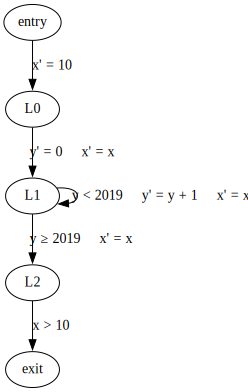

In [76]:
dcfa0 = mk_dcfa0()
dcfa0.to_dot()

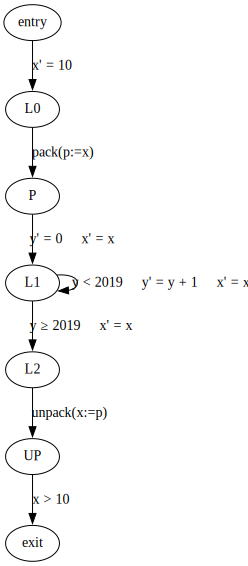

In [77]:
def mk_dcfa1():
    A = DCFA('prog4')
    ZZ = z3.IntSort()
    x, x_out = A.add_var(ZZ, 'x')
    y, y_out = A.add_var(ZZ, 'y')
    p = A.add_pack_var(ZZ, 'p')

    A.add_edge('entry', 'L0', x_out == 10)
    A.add_edge('L0', 'P', PackTr((p, x)))
    A.add_edge('P', 'L1', z3.And( y_out == 0, x_out == x ))
    A.add_edge('L1', 'L1', z3.And( y < 2019, y_out == y + 1, x_out == x ) )
    A.add_edge('L1', 'L2', z3.And(y >= 2019, x_out == x))
    A.add_edge('L2', 'UP', UnpackTr((x, p)))
    A.add_edge('UP', 'exit', x > 10)
    A.set_entry_node('entry')
    A.set_exit_node('exit')
    return A

dcfa1 = mk_dcfa1()
dcfa1.to_dot()

In [78]:
def dcfa_vc_gen(A):
    '''Verification Condition (VC) for a Data-Flow and Control Flow Automaton'''
    all_vars = A.all()
    sig = A.sig() + [z3.BoolSort()]

    Invs = dict()
    for n in A.nodes:
        inv = z3.Function(str(n), *sig)
        Invs[n] = inv

    Entry = Invs[A.entry]
    Exit = Invs[A.exit]

    # predicate for packed variables
    Pack = z3.Function('Pack', *(A.packed_sig() + [z3.BoolSort()]))
    # applied predicate
    Packed = Pack(A.pack_vars())


    vc = list()
    vc.append(z3.ForAll(all_vars, Entry(*A.pre_vars())))

    for (k, tr) in A.edges.items():
        src, dst = k
        srcP, dstP = Invs[src], Invs[dst]

        sPred = z3.BoolVal(True)
        if isinstance(tr, PackTr):
            # add clause defining Packed
            body = [srcP(*A.pre_vars())] + [p == x for (p, x) in tr.sub]
            vc.append(z3.ForAll(all_vars, z3.Implies(z3.And(*body), Packed)))

            # no-op for control-flow transition
            tr = z3.And(*[v == v_out for (v, v_out) in A.pre_post_vars()]) 
        elif isinstance(tr, UnpackTr):
            # body depends on the packed predicate
            body = [Packed]
            unpacked = set()
            # generate equalities for unpacked variables
            for x, p in tr.sub:
                unpacked.add(id(x))
                x_out = A.to_post(x)
                body.append(x_out == p)
            # all other variables are preserved over the transition
            for v, v_out in A.pre_post_vars():
                if id(v) not in unpacked:
                    body.append(v_out == v)
            tr = z3.And(*body)

        head = dstP(*A.post_vars())
        loc = srcP(*A.pre_vars())
        vc.append(z3.ForAll(all_vars, z3.Implies(z3.And(loc, tr), head)))


    vc.append(z3.ForAll(all_vars,
                        z3.Implies(Exit(*A.pre_vars()), z3.BoolVal(False))))
    return vc, {n : Invs[n](A.pre_vars()) for n in A.nodes}, Packed

In [79]:
vc, invs, pack = dcfa_vc_gen(dcfa1)
res, answer = solve_horn(vc, max_unfold=40)
res

<b>sat</b>

In [80]:
chc_to_str(vc)

"&forall;x, y, x', y', p : entry(x, y) <br/><br/>&forall;x, y, x', y', p : entry(x, y) &and; x' = 10 &rArr; L0(x', y') <br/><br/>&forall;x, y, x', y', p : L0(x, y) &and; p = x &rArr; Pack(p) <br/><br/>&forall;x, y, x', y', p : L0(x, y) &and; x = x' &and; y = y' &rArr; P(x', y') <br/><br/>&forall;x, y, x', y', p : P(x, y) &and; y' = 0 &and; x' = x &rArr; L1(x', y') <br/><br/>&forall;x, y, x', y', p :<br/> L1(x, y) &and; y &lt; 2019 &and; y' = y + 1 &and; x' = x &rArr; L1(x', y') <br/><br/>&forall;x, y, x', y', p : L1(x, y) &and; y &ge; 2019 &and; x' = x &rArr; L2(x', y') <br/><br/>&forall;x, y, x', y', p :<br/> L2(x, y) &and; Pack(p) &and; x' = p &and; y' = y &rArr; UP(x', y') <br/><br/>&forall;x, y, x', y', p : UP(x, y) &and; x &gt; 10 &rArr; exit(x', y') <br/><br/>&forall;x, y, x', y', p : exit(x, y) &rArr; False <br/><br/>"

In [81]:
answer.eval(pack)

&not;(p &ge; 11)

In [82]:
answer

[L0 = [else &rarr; &not;(&#957;<sub>0</sub> &ge; 11)],
 UP = [else &rarr; &not;(&#957;<sub>0</sub> &ge; 11)],
 L2 = [else &rarr; True],
 exit = [else &rarr; False],
 P = [else &rarr; True],
 Pack = [else &rarr; &not;(&#957;<sub>0</sub> &ge; 11)],
 L1 = [else &rarr; True],
 entry = [else &rarr; True]]

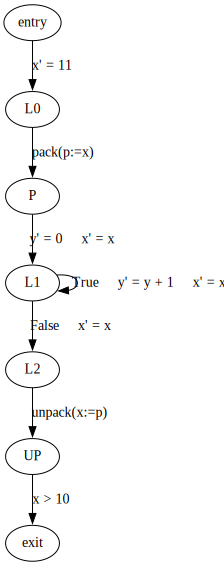

In [83]:
def mk_dcfa2():
    A = DCFA('dcfa2')
    ZZ = z3.IntSort()
    x, x_out = A.add_var(ZZ, 'x')
    y, y_out = A.add_var(ZZ, 'y')
    p = A.add_pack_var(ZZ, 'p')

    A.add_edge('entry', 'L0', x_out == 11)
    A.add_edge('L0', 'P', PackTr((p, x)))
    A.add_edge('P', 'L1', z3.And( y_out == 0, x_out == x ))
    A.add_edge('L1', 'L1', z3.And( z3.BoolVal(True), y_out == y + 1, x_out == x ) )
    A.add_edge('L1', 'L2', z3.And(z3.BoolVal(False), x_out == x))
    A.add_edge('L2', 'UP', UnpackTr((x, p)))
    A.add_edge('UP', 'exit', x > 10)
    A.set_entry_node('entry')
    A.set_exit_node('exit')
    return A

dcfa2 = mk_dcfa2()
dcfa2.to_dot()

In [84]:
vc, invs, pack = dcfa_vc_gen(dcfa2)
res, answer = solve_horn(vc, max_unfold=40)
res

<b>sat</b>

In [85]:
answer

[L0 = [else &rarr; True],
 UP = [else &rarr; False],
 exit = [else &rarr; False],
 L2 = [else &rarr; False],
 P = [else &rarr; True],
 Pack = [else &rarr; True],
 L1 = [else &rarr; True],
 entry = [else &rarr; True]]

## Conclusion

This is the end of the interactive portion of the tutorial

In [86]:
chc_to_str(vc)


"&forall;x, y, x', y', p : entry(x, y) <br/><br/>&forall;x, y, x', y', p : entry(x, y) &and; x' = 11 &rArr; L0(x', y') <br/><br/>&forall;x, y, x', y', p : L0(x, y) &and; p = x &rArr; Pack(p) <br/><br/>&forall;x, y, x', y', p : L0(x, y) &and; x = x' &and; y = y' &rArr; P(x', y') <br/><br/>&forall;x, y, x', y', p : P(x, y) &and; y' = 0 &and; x' = x &rArr; L1(x', y') <br/><br/>&forall;x, y, x', y', p :<br/> L1(x, y) &and; True &and; y' = y + 1 &and; x' = x &rArr; L1(x', y') <br/><br/>&forall;x, y, x', y', p : L1(x, y) &and; False &and; x' = x &rArr; L2(x', y') <br/><br/>&forall;x, y, x', y', p :<br/> L2(x, y) &and; Pack(p) &and; x' = p &and; y' = y &rArr; UP(x', y') <br/><br/>&forall;x, y, x', y', p : UP(x, y) &and; x &gt; 10 &rArr; exit(x', y') <br/><br/>&forall;x, y, x', y', p : exit(x, y) &rArr; False <br/><br/>"